**Feature Importance Investigation**

The goal of this notebook is to work with the cleaned & predictor-imputed & feature-reduced data to identify whether some (groups of) features might be more useful in predicting the outcomes.

In the notebook we will:

1. Import the data. These include the accelerometer predictors.
2. To try to identify predictors that might be most strongly associated with the outcome variable (PCIAT_Total), we will examine correlations between each predictor (individually) and 
    * PCIAT-PCIAT_Total
    * log(PCIAT-PCIAT_Total)
    * (PCIAT-PCIAT_Total)^2
3. Using RandomForest Regression on the entire set of predictors and examining the importance matrix to try to find a potential list of "key" predictors
4. Examining NaN counts for all variables and, potentially, removing variables that:
    * Have very large NaN counts AND
    * Don't have face value as predictors AND
    * Have low correlations with the outcome variable
5. Create sets of predictors grouped by predictors with NaNs in common (e.g., a set where a participant is likely to either have values for all of the predictors in the set or none of the predictors in the set). We will use these to try to identify whether *groups* of predictors are more important than others for predicting PCIAT scores

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the original data set
train_cleaned = pd.read_csv('train_cleaned_outcome_imputed_feature_selected.csv')

In [3]:
# Make a list of numeric features
numeric_features = train_cleaned.select_dtypes(include=[np.number]).columns

# Remove all PCIAT component variables from numeric features
numeric_features = numeric_features.drop(list(train_cleaned.filter(regex='PCIAT-PCIAT_0').columns))
numeric_features = numeric_features.drop(list(train_cleaned.filter(regex='PCIAT-PCIAT_1').columns))
numeric_features = numeric_features.drop(list(train_cleaned.filter(regex='PCIAT-PCIAT_2').columns))

# Remove sii and PCIAT-PCIAT_Total from numeric_features
numeric_features = numeric_features.drop(['sii', 'PCIAT-PCIAT_Total'])

In [4]:
# Compute absolute values of correlations between each predictor in numeric_features and PCIAT-PCIAT_Total
correlations = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['PCIAT-PCIAT_Total'])))

# Order correlations from largest to smallest
correlations = correlations.sort_values(ascending=False)

correlations.head(10)

Physical-Height                           0.417952
Basic_Demos-Age                           0.414704
PreInt_EduHx-computerinternet_hoursday    0.380958
Physical-Weight                           0.366635
BIA-BIA_FFM                               0.331195
Physical-Waist_Circumference              0.318887
FGC-FGC_CU                                0.308348
BIA-BIA_Fat                               0.282827
ENMO_Avg_Active_Days_MVPA110              0.263583
Physical-BMI                              0.250113
dtype: float64

Height, age, and weight are among the strong(er) predictors of the PCIAT_Total outcome, as well as responses to a survey about hours of internet use.

There appear to be a constellation of BIA variables that are predictors, but prior exploration suggests that these might be strongly correlated with height and weight (and maybe age), so they might be candidates for elimination.

It's possible that there are some non-linear associations. So we'll compute log and ^2 of the outcome variable and re-compute correlations

In [5]:
# Create a new variable that is log(PCIAT-PCIAT_Total)
train_cleaned['log_PCIAT-PCIAT_Total'] = np.log(train_cleaned['PCIAT-PCIAT_Total'])

# Replace -inf values in log_PCIAT-PCIAT_Total with -1
train_cleaned['log_PCIAT-PCIAT_Total'] = train_cleaned['log_PCIAT-PCIAT_Total'].replace(-np.inf, -1)

# Compute absolute values of correlations between each predictor in numeric_features and log_PCIAT-PCIAT_Total
correlations_log = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['log_PCIAT-PCIAT_Total'])))
correlations_log = correlations_log.sort_values(ascending=False)

correlations_log.head(10)

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Physical-Height                           0.371523
Basic_Demos-Age                           0.363514
PreInt_EduHx-computerinternet_hoursday    0.314995
Physical-Weight                           0.307610
FGC-FGC_CU                                0.274599
BIA-BIA_FFM                               0.267541
Physical-Waist_Circumference              0.265668
BIA-BIA_Fat                               0.226043
ENMO_Avg_Active_Days_MVPA110              0.213419
Physical-BMI                              0.201790
dtype: float64

The ordering of these variables is roughly unchanged, but the correlation values have decreased. So it doesn't seem to be the case that any of the predictors have a strong(er) correlation with log(PCIAT_Total)

In [6]:
# Create a new variable that is (PCIAT-PCIAT_Total)^2
train_cleaned['squared_PCIAT-PCIAT_Total'] = train_cleaned['PCIAT-PCIAT_Total']**2

# Compute absolute values of correlations between each predictor in numeric_features and squared_PCIAT-PCIAT_Total
correlations_squared = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['squared_PCIAT-PCIAT_Total'])))
correlations_squared = correlations_squared.sort_values(ascending=False)
correlations_squared.head(10)

Basic_Demos-Age                           0.381623
Physical-Height                           0.377574
PreInt_EduHx-computerinternet_hoursday    0.351885
Physical-Weight                           0.348412
BIA-BIA_FFM                               0.315812
BIA-BIA_Fat                               0.279299
FGC-FGC_CU                                0.268651
Physical-Waist_Circumference              0.265930
BIA-BIA_FFMI                              0.249794
ENMO_Avg_Active_Days_MVPA110              0.242638
dtype: float64

Same results for the square relationship as with log. So we'll stick with examining linear relationships. We can remove the newly-created log/square predictors

In [7]:
# Remove the log_PCIAT-PCIAT_Total and squared_PCIAT-PCIAT_Total variables
train_cleaned = train_cleaned.drop(['log_PCIAT-PCIAT_Total', 'squared_PCIAT-PCIAT_Total'], axis=1)

**Random Forest for Feature Selection**

In this section, we will run a RandomForest regressor on the set of predictors to identify variables with relatively large importance scores. We'll then use these to create a list of "key features" that we can use when comparing models.

In [8]:
#Create an initial list of predictor columns

predictors = train_cleaned.columns.tolist()
if 'id' in predictors:
    predictors.remove('id')
if 'sii' in predictors:
    predictors.remove('sii')
predictors = [x for x in predictors if 'PCIAT' not in x]
predictors = [x for x in predictors if 'Season' not in x]

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from CustomImputers import *


pipe_mice = Pipeline([('mice_impute', Custom_MICE_Imputer()),
                    ('add_zones', FunctionTransformer(zone_encoder)),
                    ('rf', RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 216))])

pipe_mice.fit(train_cleaned[predictors],train_cleaned['PCIAT-PCIAT_Total'])

train_pred_mice = pipe_mice.predict(train_cleaned[predictors])

#Get feature importance from the rf inside pipe
score_mice_df = pd.DataFrame({'feature':train_cleaned[predictors].columns,
                            'importance_score': pipe_mice.named_steps['rf'].feature_importances_})

score_mice_df.sort_values('importance_score',ascending=False)


,feature,importance_score
0,Basic_Demos-Age,0.134744
20,PreInt_EduHx-computerinternet_hoursday,0.128712
4,Physical-Height,0.113239
14,BIA-BIA_FFM,0.088525
19,SDS-SDS_Total_Raw,0.075877
5,Physical-Weight,0.073809
22,ENMO_Avg_Active_Days_MVPA110,0.070334
10,FGC-FGC_CU,0.051529
6,Physical-Waist_Circumference,0.026613
17,BIA-BIA_Fat,0.024879


In [10]:
# Include the features with scores at least 0.05 as "keyfeatures"

keyfeatures = ['Basic_Demos-Age',
 'Physical-Height',
 'PreInt_EduHx-computerinternet_hoursday',
 'BIA-BIA_FFM',
 'SDS-SDS_Total_Raw',
 'Physical-Weight',
 'ENMO_Avg_Active_Days_MVPA110',
 'FGC-FGC_CU']

**Exploring Features Grouped by Missing-Ness**

There is a lot of missing data. The NaN values usually occur in groups - e.g., a participant is missing data for all of the BIA variables. In the next section, we'll see if some of these groups of variables seem to better predict the outcome than others.

In [11]:
# List the number of NaN values for each variable
train_cleaned.isnull().sum().sort_values(ascending=False).head(20)

Physical-Waist_Circumference        1818
Fitness_Endurance_Total_Time_Sec    1599
ENMO_Avg_Active_Days_MVPA192        1398
ENMO_Avg_Active_Days_MVPA110        1398
Positive_Anglez_Active_Days         1398
BIA-BIA_FMI                          763
BIA-BIA_Fat                          763
PAQ_Total                            753
PAQ_Zone                             753
BIA-BIA_FFMI                         745
BIA-BIA_FFM                          739
BIA-BIA_Activity_Level_num           738
BIA-BIA_Frame_num                    738
FGC-FGC_PU                           667
FGC-FGC_CU                           664
FGC-FGC_SR                           660
FGC-FGC_SR_Zone                      660
FGC-FGC_TL                           655
CGAS-CGAS_Score                      301
Physical-Diastolic_BP                220
dtype: int64

There are some variables with a *lot* of missing information. But maybe the distribution (among participants) of number of NaN values is bimodal - perhaps there are a lot of people who are missing data for most of the variables.

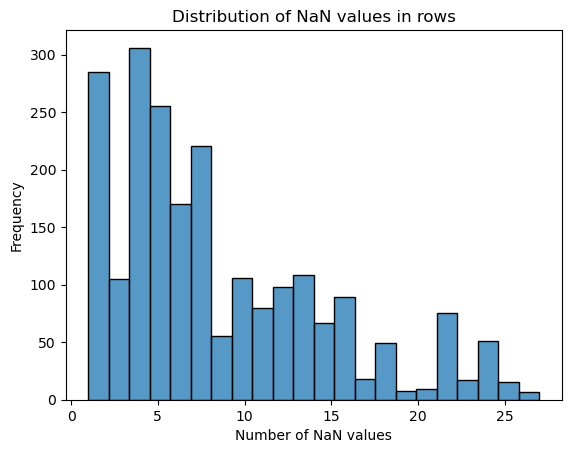

In [12]:
# Count the number of NaN values for each row and create a histogram of the distribution of these values
train_cleaned['NaN_count'] = train_cleaned.isnull().sum(axis=1)
sns.histplot(train_cleaned['NaN_count'])
plt.xlabel('Number of NaN values')
plt.ylabel('Frequency')
plt.title('Distribution of NaN values in rows')
plt.show()

The distribution looks multimodal. There are ~450 people who are missing data for nearly all of the variables, a group who are missing data for a few, and then no other groups that really stand out

These numbers are probably affected by the grouping into Physical, FitnessGram, and BIA—it seems likely that individuals would either have data for all of the predictors in a category or none of the predictors.

Doing regression requires values for all predictors. So we'll need to do one of the following: 
1. Focus on the ~300 participants who have data for (nearly) all of the variables, 
2. Focus only on the variables for which all participants have data
3. Some balance between these options -- eliminate a small number of high-NaN variables and then eliminate participants with NaN values in the remaining variables.

Alterntively, we can use imputation to fill in missing values.

Let's get a sense of how many independent features there really are. We'll figure out whether the Physical, FGC, and BIA variables tend to all be missing together. The goal is to create sets of variables that are all either present or not. We can then include these sets (or not) in various prediction methods.

The sets below were created by initially grouping variables by label (e.g., all variables that started with 'Physical'), then looking at the distribution of NaN counts. Bimodality in the distribution indicated that participants either had data for all of the variables in the group or had data for none of the variables in the group. If the distribution had more than two modes, the set was split into subsets that were bimodal 

In [13]:
# Create a list of all columns for each "group" of variables

physical_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Physical') & train_cleaned.columns.isin(numeric_features)]
physical_features = physical_features.drop('Physical-Waist_Circumference')

physical_features_waist = ['Physical-Waist_Circumference']

FGC_GS_features = train_cleaned.columns[train_cleaned.columns.str.startswith('FGC-FGC_GS') & train_cleaned.columns.isin(numeric_features)]

FGC_features = train_cleaned.columns[train_cleaned.columns.str.startswith('FGC') & train_cleaned.columns.isin(numeric_features)]
#FGC_features = FGC_features.append(pd.Index(['FitnessGram_Zone_Total']))
FGC_features = FGC_features.drop(FGC_GS_features)

BIA_features = train_cleaned.columns[train_cleaned.columns.str.startswith('BIA') & train_cleaned.columns.isin(numeric_features)]

PAQ_features = train_cleaned.columns[train_cleaned.columns.str.startswith('PAQ') & train_cleaned.columns.isin(numeric_features)]

SDS_features = train_cleaned.columns[train_cleaned.columns.str.startswith('SDS') & train_cleaned.columns.isin(numeric_features)]

fitness_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Fitness_') & train_cleaned.columns.isin(numeric_features)]

Basic_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Basic') & train_cleaned.columns.isin(numeric_features)]

ENMO_features = ['ENMO_Avg_Active_Days_MVPA192', 'ENMO_Avg_Active_Days_MVPA110', 'Positive_Anglez_Active_Days']

PreInt_features = ['PreInt_EduHx-computerinternet_hoursday']


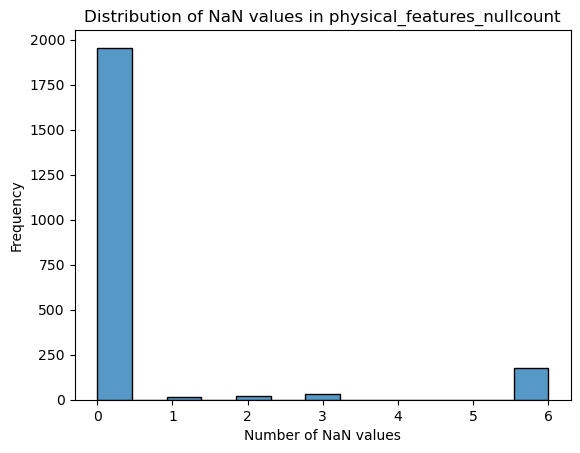

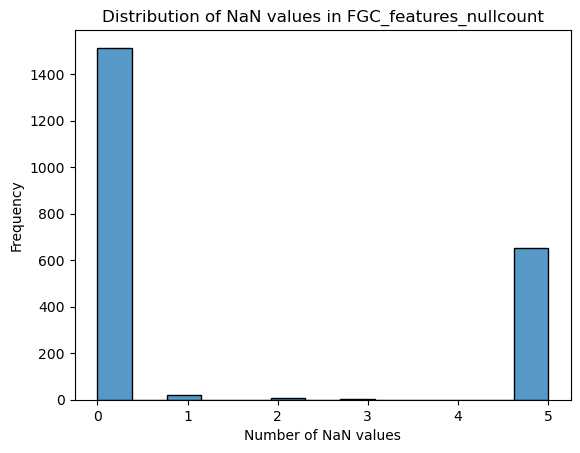

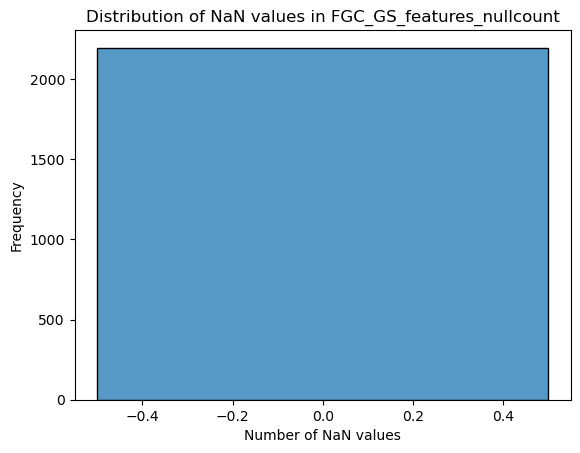

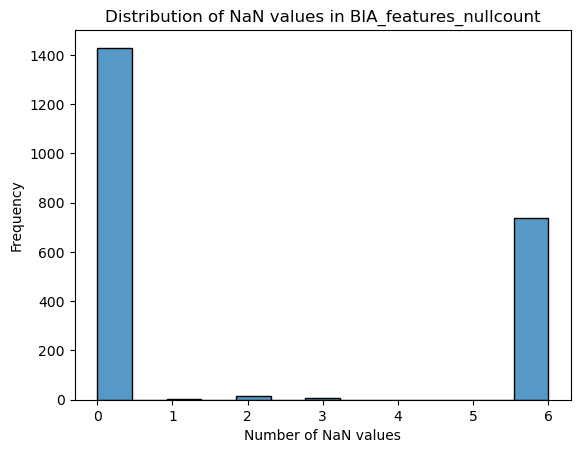

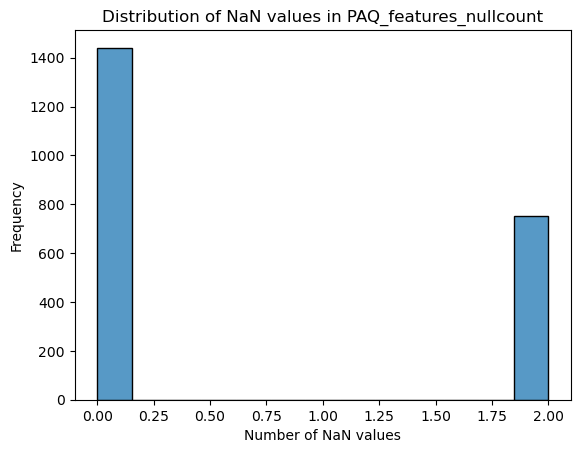

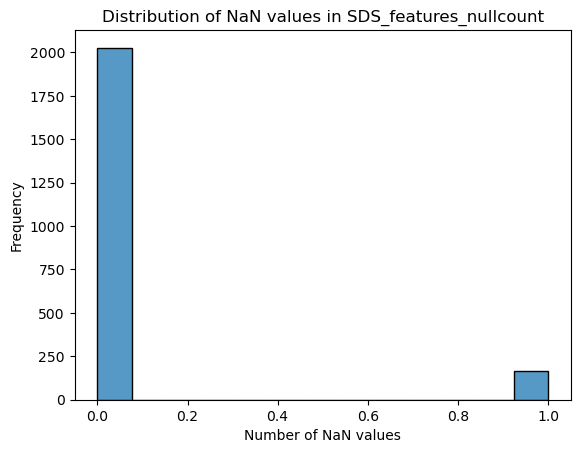

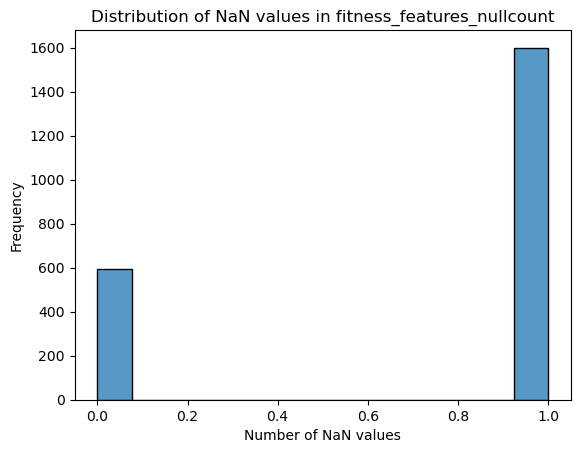

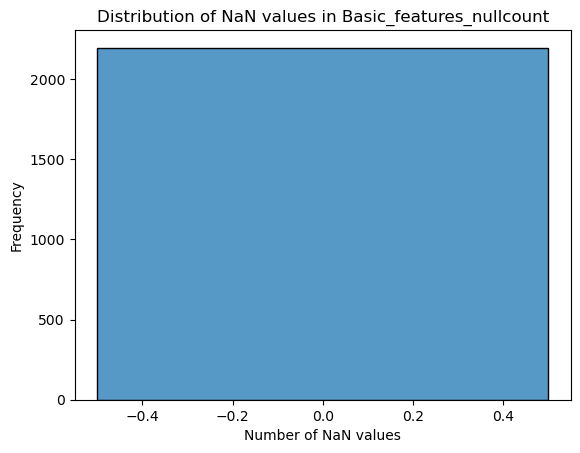

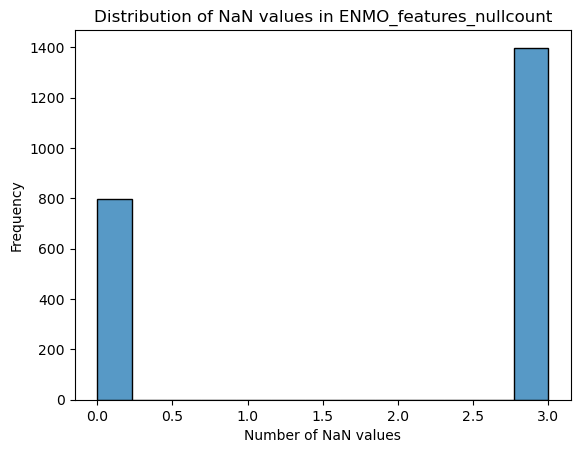

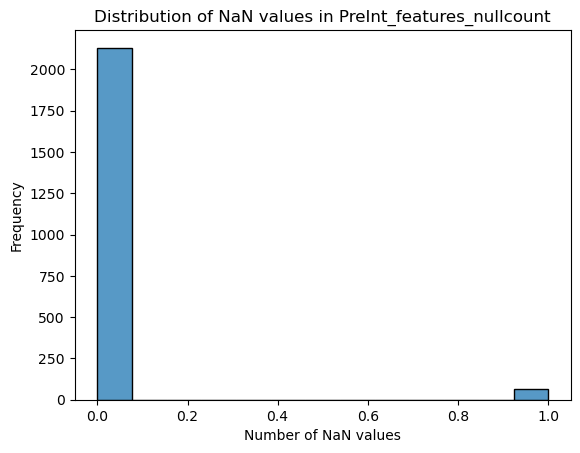

In [14]:
# Create a new variable that counts the number of NaN values among variables in the physical_features list
train_cleaned['physical_features_nullcount'] = train_cleaned[physical_features].isnull().sum(axis=1)
train_cleaned['FGC_features_nullcount'] = train_cleaned[FGC_features].isnull().sum(axis=1)
train_cleaned['FGC_GS_features_nullcount'] = train_cleaned[FGC_GS_features].isnull().sum(axis=1)
train_cleaned['BIA_features_nullcount'] = train_cleaned[BIA_features].isnull().sum(axis=1)
train_cleaned['PAQ_features_nullcount'] = train_cleaned[PAQ_features].isnull().sum(axis=1)
train_cleaned['SDS_features_nullcount'] = train_cleaned[SDS_features].isnull().sum(axis=1)
train_cleaned['fitness_features_nullcount'] = train_cleaned[fitness_features].isnull().sum(axis=1)
train_cleaned['Basic_features_nullcount'] = train_cleaned[Basic_features].isnull().sum(axis=1)
train_cleaned['ENMO_features_nullcount'] = train_cleaned[ENMO_features].isnull().sum(axis=1)
train_cleaned['PreInt_features_nullcount'] = train_cleaned[PreInt_features].isnull().sum(axis=1)

# Make a set of histograms for each variable that ends in '_nullcount'
for feature in train_cleaned.columns:
    if feature.endswith('_nullcount'):
        sns.histplot(train_cleaned[feature])
        plt.xlabel('Number of NaN values')
        plt.ylabel('Frequency')
        plt.title('Distribution of NaN values in ' + feature)
        plt.show()

In [15]:
# Remove variables from train_cleaned that end with _nullcount
train_cleaned = train_cleaned.loc[:,~train_cleaned.columns.str.endswith('_nullcount')]

# Remove the NaN_Count variable from train_cleaned
train_cleaned = train_cleaned.drop('NaN_count', axis=1)

**Predictive Power for Groups of Predictors**

In this section, we'll explore whether groups of variables (as opposed to single variables) might be better predictors of PCIAT.

We'll start creating linear models using all combinations of the predictor sets

There are 11 predictor sets, so there will be a total of 2^11=2048 combinations of sets

For each combination, we'll do a 5-fold cross-validation and compute the mean MSE

Then we'll look at the combinations of predictor sets with the lowest mean MSE

The computations seem to be winnowing down the size of the data set more than anticipated, so I'll be inserting some additional code to see where this is happening

In [16]:
# Load all the things we'll need
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# First, split the entire data set into training and testing to use as a final check on the models we build
# Setting a value for random_state to diagnose buggy code
Training_Set, Testing_Set = train_test_split(train_cleaned,
                                                       shuffle = True,
                                                       random_state = 216,
                                                       test_size = .2)

In [17]:
# Count the number of NaN values in PCIAT-PCIAT_Total in train_cleaned, Training_Set, and Testing_Set:
print('Number of total entries in the train_cleaned:', len(train_cleaned))
print('Number of non-NaN entries in the train_cleaned:', len(train_cleaned) - train_cleaned['PCIAT-PCIAT_Total'].isna().sum())

print('Number of total entries in the Training_Set:', len(Training_Set))
print('Number of non-NaN entries in PCIAT_Total for Training_Set:', len(Training_Set) - Training_Set['PCIAT-PCIAT_Total'].isna().sum())

print('Number of total entries in the Testing_Set:', len(Testing_Set))
print('Number of non-NaN entries in PCIAT_Total for Testing_Set:', len(Testing_Set) - Testing_Set['PCIAT-PCIAT_Total'].isna().sum())

Number of total entries in the train_cleaned: 2194
Number of non-NaN entries in the train_cleaned: 2194
Number of total entries in the Training_Set: 1755
Number of non-NaN entries in PCIAT_Total for Training_Set: 1755
Number of total entries in the Testing_Set: 439
Number of non-NaN entries in PCIAT_Total for Testing_Set: 439


In [18]:
# Next we'll set up the power set of the groups and create a dataframe to hold the members of the power set and the mean MSE for that collection

# Create a list of all columns for each "group" of variables
physical_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Physical') & train_cleaned.columns.isin(numeric_features)]
physical_features = physical_features.drop('Physical-Waist_Circumference')
physical_features_waist = ['Physical-Waist_Circumference']
FGC_features = train_cleaned.columns[train_cleaned.columns.str.startswith('FGC') & train_cleaned.columns.isin(numeric_features)]
BIA_features = train_cleaned.columns[train_cleaned.columns.str.startswith('BIA') & train_cleaned.columns.isin(numeric_features)]
PAQ_features = train_cleaned.columns[train_cleaned.columns.str.startswith('PAQ') & train_cleaned.columns.isin(numeric_features)]
SDS_features = train_cleaned.columns[train_cleaned.columns.str.startswith('SDS') & train_cleaned.columns.isin(numeric_features)]
fitness_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Fitness_') & train_cleaned.columns.isin(numeric_features)]
Basic_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Basic') & train_cleaned.columns.isin(numeric_features)]
ENMO_features = ['ENMO_Avg_Active_Days_MVPA192', 'ENMO_Avg_Active_Days_MVPA110', 'Positive_Anglez_Active_Days']
PreInt_features = ['PreInt_EduHx-computerinternet_hoursday']


# Create a list of all groups of features
groups = [physical_features, physical_features_waist, FGC_features, BIA_features, PAQ_features, SDS_features, fitness_features, Basic_features, ENMO_features, PreInt_features]

# This function returns the power set of a set minus the empty set.  
def powerset(s):
    power_set = [[]]
    for x in s:
        power_set += [s0+[x] for s0 in power_set]
    return power_set[1:]

# Create the power set of the groups of features
features_groups_powerset = powerset(groups)

## This is the baseline model
features_groups_powerset.append([['baseline']])

# Each element of the powerset is a list of lists. To extract the features from each list of lists, we'll need to be able to 'flatten' the list of lists into a list
def flatten(inlist):
    flat_list = []
    for element in inlist:
        flat_list.extend(element)
    return flat_list

In [19]:
# Set up a 5-fold split to use with the linear models
num_splits = 5

#Create a numpy array with num_splits columns and len(features_groups_powerset) rows to hold the MSE values
cv_mses = np.zeros((len(features_groups_powerset), num_splits))

#Create a numpy array with len(features_groups_powerset) rows to hold the number of valid observations in each split
cv_sizes = np.zeros((len(features_groups_powerset), num_splits))

#Make a KFold object; setting random_state for now to help diagnose any issues with the code
kfold = KFold(num_splits,
              random_state = 216,
              shuffle=True)

## loop through all splits
i = 0
for train_index, test_index in kfold.split(Training_Set):
    #print('Iteration:',i)
    ## get train and holdout sets
    problematic_train_train = Training_Set.iloc[train_index]
    problematic_train_holdout = Training_Set.iloc[test_index]

    #loop through all models
    j = 0
    for featureset in features_groups_powerset:
        #print('Featureset:',featureset)
        featureset_flattened = flatten(featureset)
        #print('Featureset Flattened:',featureset_flattened)

        if featureset_flattened == ['baseline']:
            #print('Featureset was baseline')
        
            # Drop NaNs from problematic_train_train for the 'PCIAT-PCIAT_Total' variable
            problematic_train_train_copy = problematic_train_train.dropna(subset=['PCIAT-PCIAT_Total'])
            #print('NaNs dropped from train_train')
            #print('Remaining observations in train set is', len(problematic_train_train_copy))
            problematic_train_holdout_copy = problematic_train_holdout.dropna(subset=['PCIAT-PCIAT_Total'])
            #print('NaNs dropped from train_holdout')
            #print('Remaining observations in holdout set is', len(problematic_train_holdout_copyp))

            cv_sizes[j,i] = len(problematic_train_train_copy)+len(problematic_train_holdout_copy)

            if len(problematic_train_train_copy)>0 and len(problematic_train_holdout_copy)>0:
                problematic_train_train_mean = problematic_train_train_copy['PCIAT-PCIAT_Total'].mean()
                #print('Prediction is:',problematic_train_train_mean)
                predict = problematic_train_train_mean * np.ones(len(problematic_train_holdout_copy))
                cv_mses[j,i] = mean_squared_error(problematic_train_holdout_copy['PCIAT-PCIAT_Total'], predict)
                #print('Value has been set')
            else: cv_mses[j,i]=np.nan
        else:
            # Drop NaNs from problematic_train_train where the variables are either in featureset_flattened or are equal to 'PCIAT-PCIAT_Total'
            problematic_train_train_copy = problematic_train_train.dropna(subset=featureset_flattened + ['PCIAT-PCIAT_Total'])
            #print('NaNs dropped from train_train')
            #print('Remaining observations in train set is', len(problematic_train_train))
            problematic_train_holdout_copy = problematic_train_holdout.dropna(subset=featureset_flattened + ['PCIAT-PCIAT_Total'])
            #print('NaNs dropped from train_holdout')
            #print('Remaining observations in holdout set is', len(problematic_train_holdout))

            cv_sizes[j,i] = len(problematic_train_train_copy)+len(problematic_train_holdout_copy)

            if len(problematic_train_train_copy)>0 and len(problematic_train_holdout_copy)>0:
                ## make clone
                reg = LinearRegression(copy_X = True)
            
                ## fit clone
                reg.fit(problematic_train_train_copy[featureset_flattened], problematic_train_train_copy['PCIAT-PCIAT_Total'])
                #print('LinReg has been fit')
                predict = reg.predict(problematic_train_holdout_copy[featureset_flattened])
                #print('LinReg has been predicted')

                # Set the value of feature_combinations where the value of 'predictor_list' is equal to featureset and the column is equal to i
                cv_mses[j,i] = mean_squared_error(problematic_train_holdout_copy['PCIAT-PCIAT_Total'], predict)
                #print('Value has been set')
            else:
                cv_mses[j,i] = np.nan
        j=j+1
    i=i+1

In [20]:
# Compute the mean of each row in cv_mses
cv_mses_means = np.mean(cv_mses, axis=1)

# Compute the mean of each row in cv_sizes
cv_sizes_means = np.mean(cv_sizes, axis=1)

# Create a new dataframe where the first column is features_groups_powerset and the second column is cv_mses_means
MSE_Group_Comparison = pd.DataFrame({'featureset': features_groups_powerset, 'Mean_MSE': cv_mses_means, 'Non_NAN_Observations':cv_sizes_means})


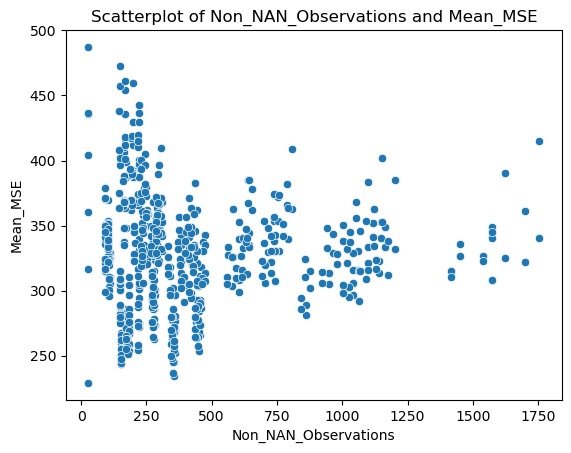

In [21]:
# Create a scatterplot of Non_NAN_Observations and Mean_MSE in MSE_Group_Comparison_filtered. Add a trendline
sns.scatterplot(data=MSE_Group_Comparison[MSE_Group_Comparison['Mean_MSE'] < 500], x='Non_NAN_Observations', y='Mean_MSE')
plt.xlabel('Non_NAN_Observations')
plt.ylabel('Mean_MSE')
plt.title('Scatterplot of Non_NAN_Observations and Mean_MSE')
plt.show()

**Interpretation**

This graph shows that there is some tradeoff between predictive power (i.e., low MSE) and availability of data (i.e., large numbers of non-NAN observations)

In the sections below, we'll try to identify a couple of collections of variables that have various balances between these tradeoffs

In [22]:
# Compute a metric to try to balance large observations and small MSE
MSE_Group_Comparison['Non_NAN_Observations_divided_by_Mean_MSE'] = MSE_Group_Comparison['Non_NAN_Observations'] / MSE_Group_Comparison['Mean_MSE']

In [23]:
MSE_Group_Comparison.sort_values(by='Non_NAN_Observations_divided_by_Mean_MSE', ascending=False).head(10)

,featureset,Mean_MSE,Non_NAN_Observations,Non_NAN_Observations_divided_by_Mean_MSE
639,"[[Basic_Demos-Age, Basic_Demos-Sex], [PreInt_E...",322.317250,1701.0,5.277409
127,"[[Basic_Demos-Age, Basic_Demos-Sex]]",340.710641,1755.0,5.150998
671,"[[SDS-SDS_Total_Raw], [Basic_Demos-Age, Basic_...",308.242365,1573.0,5.103127
159,"[[SDS-SDS_Total_Raw], [Basic_Demos-Age, Basic_...",325.087318,1623.0,4.992505
640,"[[Physical-BMI, Physical-Height, Physical-Weig...",322.452866,1538.0,4.769689
511,[[PreInt_EduHx-computerinternet_hoursday]],360.980217,1701.0,4.712170
512,"[[Physical-BMI, Physical-Height, Physical-Weig...",326.942746,1538.0,4.704188
128,"[[Physical-BMI, Physical-Height, Physical-Weig...",340.322171,1573.0,4.622091
672,"[[Physical-BMI, Physical-Height, Physical-Weig...",310.140773,1418.0,4.572117
543,"[[SDS-SDS_Total_Raw], [PreInt_EduHx-computerin...",344.900336,1573.0,4.560738


In [24]:
# Identify rows in MSE_Group_Comparison with Mean_MSE less than 296 and Non_NAN_Observations between 750 and 1100
MSE_Group_Comparison[(MSE_Group_Comparison['Mean_MSE'] < 296) & (MSE_Group_Comparison['Non_NAN_Observations'] > 750) & (MSE_Group_Comparison['Non_NAN_Observations'] < 1100)]

,featureset,Mean_MSE,Non_NAN_Observations,Non_NAN_Observations_divided_by_Mean_MSE
555,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_TL, FGC-FGC_...",288.942376,862.0,2.983294
556,"[[Physical-BMI, Physical-Height, Physical-Weig...",293.985345,843.0,2.867490
675,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_TL, FGC-FGC_...",291.825216,1066.0,3.652871
679,"[[BIA-BIA_Activity_Level_num, BIA-BIA_FFM, BIA...",294.704555,1025.0,3.478060
683,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_TL, FGC-FGC_...",280.893217,862.0,3.068782
684,"[[Physical-BMI, Physical-Height, Physical-Weig...",285.895033,843.0,2.948635


In [25]:
# Identify rows in MSE_Group_Comparison where the featureset string includes 'ENMO'
ENMO_Comparison = MSE_Group_Comparison[MSE_Group_Comparison['featureset'].astype(str).str.contains('ENMO')]

In [26]:
# Sort ENMO_Comparison by Non_NAN_Observations_divided_by_Mean_MSE
ENMO_Comparison.sort_values(by='Non_NAN_Observations_divided_by_Mean_MSE', ascending=False).head(10)

,featureset,Mean_MSE,Non_NAN_Observations,Non_NAN_Observations_divided_by_Mean_MSE
895,"[[Basic_Demos-Age, Basic_Demos-Sex], [ENMO_Avg...",313.108929,637.0,2.034436
896,"[[Physical-BMI, Physical-Height, Physical-Weig...",310.625507,617.0,1.986315
768,"[[Physical-BMI, Physical-Height, Physical-Weig...",315.520595,617.0,1.955498
383,"[[Basic_Demos-Age, Basic_Demos-Sex], [ENMO_Avg...",335.293073,642.0,1.914743
927,"[[SDS-SDS_Total_Raw], [Basic_Demos-Age, Basic_...",303.769519,577.0,1.899466
767,"[[ENMO_Avg_Active_Days_MVPA192, ENMO_Avg_Activ...",340.059829,637.0,1.873200
384,"[[Physical-BMI, Physical-Height, Physical-Weig...",332.651409,621.0,1.866819
928,"[[Physical-BMI, Physical-Height, Physical-Weig...",304.939388,558.0,1.829872
256,"[[Physical-BMI, Physical-Height, Physical-Weig...",340.384000,621.0,1.824410
800,"[[Physical-BMI, Physical-Height, Physical-Weig...",310.186447,558.0,1.798918


In [27]:
# Sort MSE_Group_Comparison by Mean_MSE
MSE_Group_Comparison.sort_values(by='Mean_MSE').head(10)

,featureset,Mean_MSE,Non_NAN_Observations,Non_NAN_Observations_divided_by_Mean_MSE
773,"[[Physical-Waist_Circumference], [FGC-FGC_CU, ...",229.133472,28.0,0.122200
743,"[[BIA-BIA_Activity_Level_num, BIA-BIA_FFM, BIA...",234.060774,355.0,1.516700
747,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_TL, FGC-FGC_...",236.748366,352.0,1.486811
967,"[[BIA-BIA_Activity_Level_num, BIA-BIA_FFM, BIA...",243.788479,154.0,0.631695
999,"[[BIA-BIA_Activity_Level_num, BIA-BIA_FFM, BIA...",244.063829,152.0,0.622788
615,"[[BIA-BIA_Activity_Level_num, BIA-BIA_FFM, BIA...",245.115399,355.0,1.448297
619,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_TL, FGC-FGC_...",245.155305,352.0,1.435825
1003,"[[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_TL, FGC-FGC_...",247.310210,152.0,0.614613
744,"[[Physical-BMI, Physical-Height, Physical-Weig...",248.107157,347.0,1.398589
748,"[[Physical-BMI, Physical-Height, Physical-Weig...",249.728503,344.0,1.377496


Two candidates for our sets are where
* Non_NAN_Observations = 1566 and Mean_MSE=296.874168 (index 1343)
* Non_NAN_Observations = 1043 and Mean_MSE = 280.300321 (index 1351)

These sets of predictors are, respectively:
* SDS_features, Basic_Features, and PreInt_features
* FGC_features, SDS_features, Basic_Features, and PreInt_features

If we wanted to include ENMO features, we could include:
* Non_NAN_Observations = 626 and Mean_MSE = 302.116609 (index 1791)
* Non_NAN_Observations = 570 and Mean_MSE = 296.152815 (index 1855)

These sets of predictors are, respectively:
* ENMO_Features, Basic_Features, and PreInt_features
* ENMO_Features, SDS_features, Basic_Features, and PreInt_features

If we wanted to minimize MSE, we could use:
* Non_NAN_Observations = 219 and Mean_MSE = 238.084131 (index 1527)
* Non_NAN_Observations = 346 and Mean_MSE = 243.001698 (index 1495)

These sets of predictors are, respectively:
* FGC_Feagures, BIA_Features, PAQ_Features, SDS_Features, Fitness_Features, Basic_Features, and PreInt_features
* FGC_Features, BIA_Features, SDDS_Features, Fitness_Features, Basic_Features, and PreInt_features

**Interpretation**

These sets provide us with some candidates for "key features" we could use to test linear models as predictors of PCIAT scores.

The sets that minimize MSE end up including most of the available predictors. The key features identified through the random forest appear to more efficiently identify predictors within each of these groups, so we'll stick with the keyfeatures list generated above.